# No YOU hang up!
### How to get our customers to stay on the line
- INSERT cover image

In [1]:
# imports
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# import sklearn helper functions
import sklearn.feature_selection as feat_select
from sklearn.preprocessing import LabelEncoder, normalize # <-- double check to see if you need this one

# import models
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# set seaborn defaults
sns.set_palette('plasma')

# import custom modules
import acquire
import prepare
from explore import plot_counts

#ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

# Project Intro - Setting the Scene
- Goals Problems and Drivers
- many of you may have watched my presentation to the VP of Operations last month, that's our jumping off point (a link to the Tableau slide deck is located in the README of this repo)
- I found that 50% of month to month customers who churn, do so in the first 7 months
- I mentioned that with further analysis I would like to take a closer look at this problem of early churn

# Executive Summary - Conclusions & Next Steps
- I found that Model 4 (a Random Forest) performed best, using most of the features in our dataset
    - Accuracy on validate was 91.7%
    - Recall was 67%
    - Accuracy on Test 89.3% accuracy which was only slighly lower than our accuracy on validate set
    - Recall stayed pretty high (relatively so) as well 64.9%
- Dive down into feature selection and engineering to see if this can bump up model performance
- Splitting up the data further and running tests on only the Month to Month customers
- Split up data to hide tenure, and only do customers who've been with the company for a year

## How did I prepare?
- trello board
- gather deliverables
- read rubric 6 times

## What I set out to find <------ work on this formatting
- *Drivers of early churn*
- ### <font color=purple>**What makes customers leave within first year?**</font>
## Can we predict that? 
### *Yes* but how!?
 

## Plan for today
- How? 
    - exploration, testing, and modeling
- What I discovered? 
     - Payment type and Having internet service were found to be not independent of whether or not customers churn in the first year
     - Not something I had looked at in my first presentation nice to find
 

## churning in early months can we predict that?
### YES! but how
## what are some factors that statsitcally contribute to that


<hr style="border-top: 10px groove #5302a3; margin-top: 1px; margin-bottom: 1px"></hr>

# Acquire

In [2]:
# use acquire function to obtain dataframe
df = acquire.get_telco_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   churn                     7043 non-null   object 
 2   gender                    7043 non-null   object 
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   object 
 5   dependents                7043 non-null   object 
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   object 
 8   multiple_lines            7043 non-null   object 
 9   online_security           7043 non-null   object 
 10  online_backup             7043 non-null   object 
 11  device_protection         7043 non-null   object 
 12  tech_support              7043 non-null   object 
 13  streaming_tv              7043 non-null   object 
 14  streamin

### What I needed to change
<img src="images/screenshot1.png" alt="columns" width="500"/>


In [4]:
# When exploring this set before I knew there were empty values in the total_charges column
# This column type is object, there are 11 'blanks', those blanks turned out to be spaces
# Added a str.replace aspect to my prepare module
df.total_charges.value_counts()

20.2       11
           11
19.75       9
19.65       8
19.9        8
           ..
5727.15     1
1622.45     1
1534.75     1
5330.2      1
185.55      1
Name: total_charges, Length: 6531, dtype: int64

In [5]:
# this went into my prepare function, replace the space with the string 0 then change to a float
df.total_charges = df.total_charges.str.replace(' ', '0').astype(float)


<hr style="border-top: 10px groove #8b0aa5; margin-top: 1px; margin-bottom: 1px"></hr>


# Prepare

## Cleaning checklist 
(26 columns to start)
- [x] drop duplicate columns (done in SQL) (23 columns now)

create two seperate prepares **prepare_explore** and **prepare_model**

- will leave in Yes's and No's for readability in explore section

<font color='#b83289'> **prepare_explore** </font>

- [x] find and deal with empty values (11 empty ones in total_charges)
- [x] change money columns to floats
- [x] split train test

<font color='#febd2a'>  **prepare_model**  </font> 
- [x] change all yes's and no's to 0s and 1s
- [x] change all obejcts to numbers (except where nessicary)
- [x] drop all '_id' columns
- [x] create new feature, *'less_than_a_year'* from tenure and churn

#### Things I was looking for: what the overall snapshot of the data, who are the customers in this dataset?

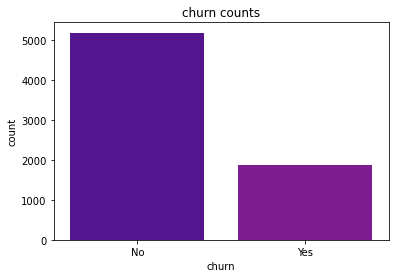

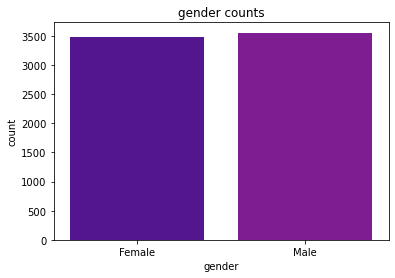

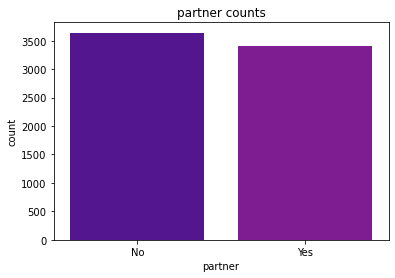

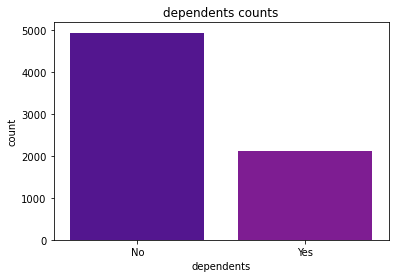

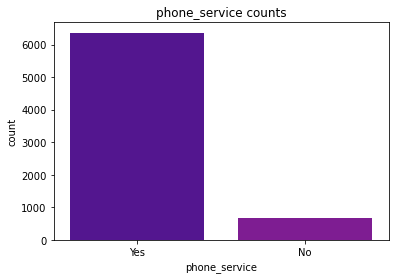

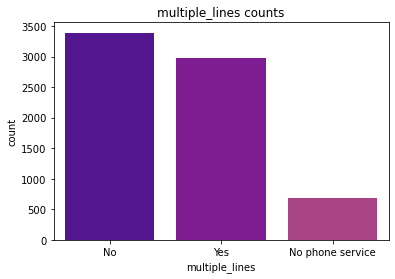

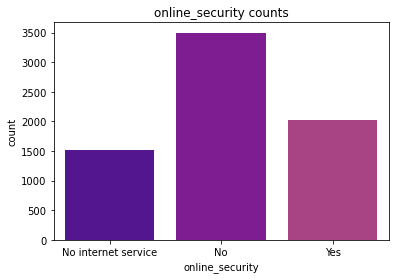

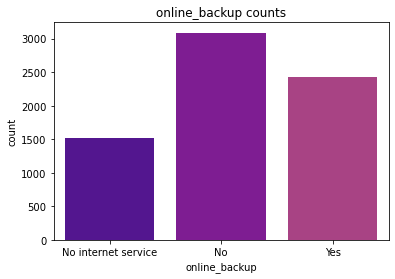

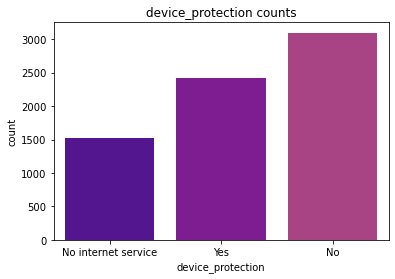

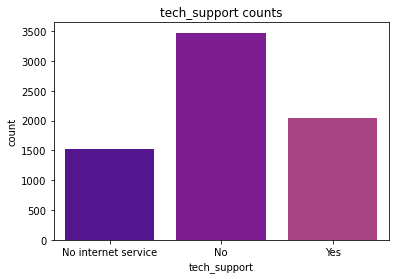

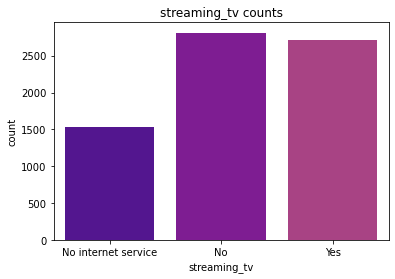

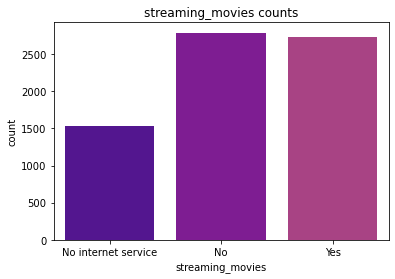

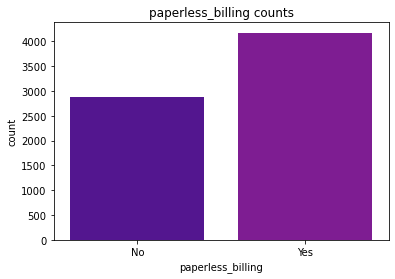

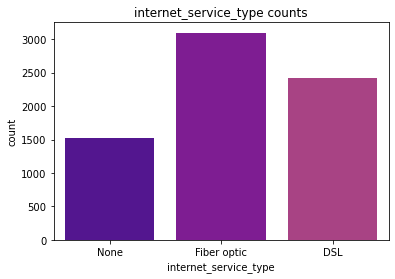

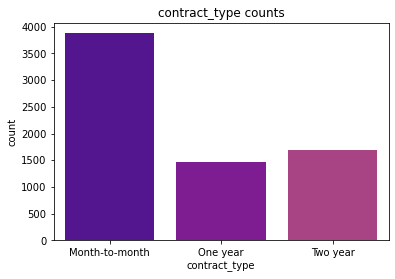

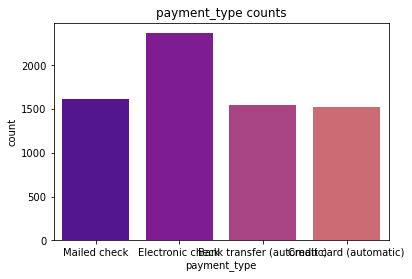

In [6]:
# use function from acquire for plotting counts
plot_counts(df)

### Takeaways from Bar plots
- Not a lot of customers don't have phone service
- A lot of customers in this data *don't churn*

## Do I have enough data points to answer the question?
- I am looking for enough people who churned in the first 12 months
- I know from previous project half of month to month customers leave within the first year, so I'm confident I'll have enough data to work with

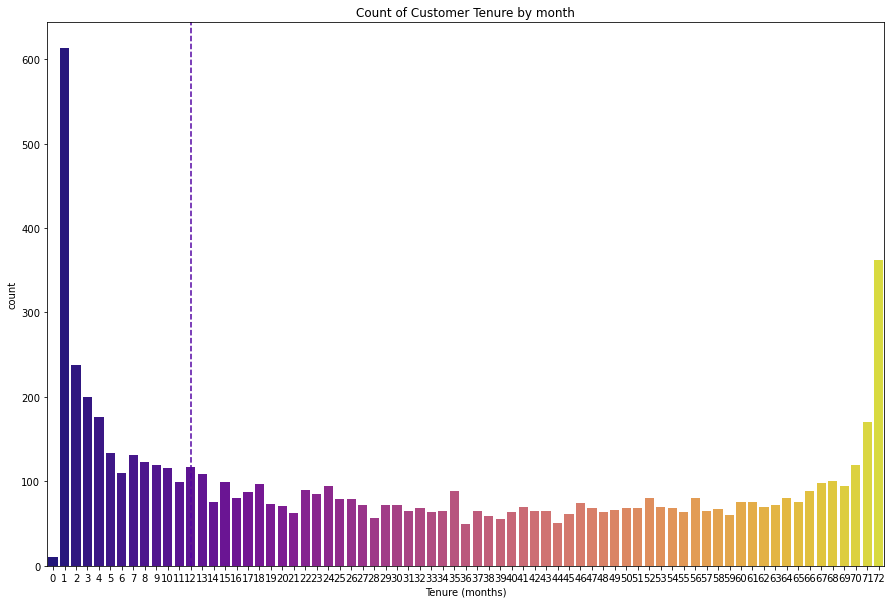

In [17]:
# plot the counts of customer tenure by month, purple line is 1 year
plt.figure(figsize=(15,10))
sns.countplot(df.tenure, palette=('plasma'))
plt.title('Count of Customer Tenure by month')
plt.xlabel('Tenure (months)')
plt.axvline(x=12, linestyle= '--')
plt.show()

In [11]:
# I tried to see if there was enough data for me to look at only the people who churned in the first year
print(df.churn.value_counts()), 
print(f'\nTotal datapoints: {df.churn.count()}')

No     5174
Yes    1869
Name: churn, dtype: int64

Total datapoints: 7043


In [13]:
# it seemed there was a sizeable amount of customers who had tenure less than a year
print(df[df.tenure < 12].churn.value_counts())
print(f'\n Total Datapoints with tenure < 12 months: {df[df.tenure < 12].churn.count()}')

No     1070
Yes     999
Name: churn, dtype: int64

 Total Datapoints with tenure < 12 months: 2069


### It looks like I'll have enough data to move on. Here is where. I decided to make a new column for the next phase

<hr style="border-top: 10px groove #b83289; margin-top: 1px; margin-bottom: 1px"></hr>

# Explore 

In [15]:
# use function from prepare to get reaty to explore
train, validate, test = prepare.prep_telco(acquire.get_telco_data())

In [16]:
# Change senior_citizen to astype string for exploration. The 0s and 1s were not helpful yet
train.senior_citizen = train.senior_citizen.astype(str)

In [50]:
# split columns into two sections discrete and continous variables
cols_discrete = ['gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'internet_service_type',
 'contract_type',
 'payment_type']

cols_continuous = [ 'monthly_charges',
         'total_charges', 'tenure']

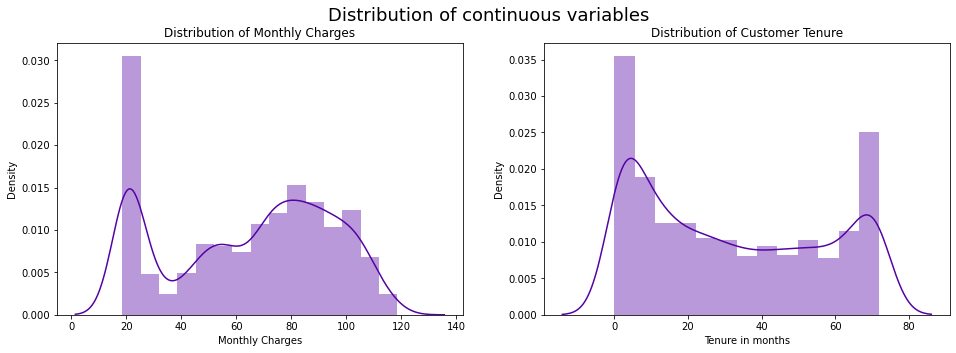

In [43]:
# distribution of Monthly Charges

plt.figure(figsize = (16,5))
plt.subplot(121)
sns.distplot(x = train.monthly_charges)
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')

# distribution of tenure
plt.subplot(122)
sns.distplot(x = train.tenure)
plt.title('Distribution of Customer Tenure')
plt.xlabel('Tenure in months')

plt.suptitle('Distribution of continuous variables', fontsize = 18)
plt.show()

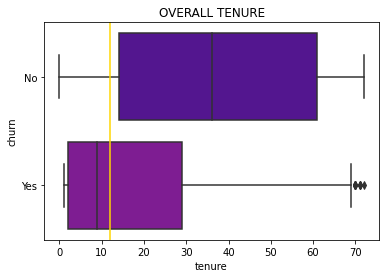

In [47]:
# this is the entire demographic! 
# compare this to all the variables to see a difference
sns.boxplot(x = train.tenure, y = train.churn)
# plot horizontal line at the 12 month mark
plt.axvline(x = 12, c='gold')
plt.title('OVERALL TENURE')
plt.show()

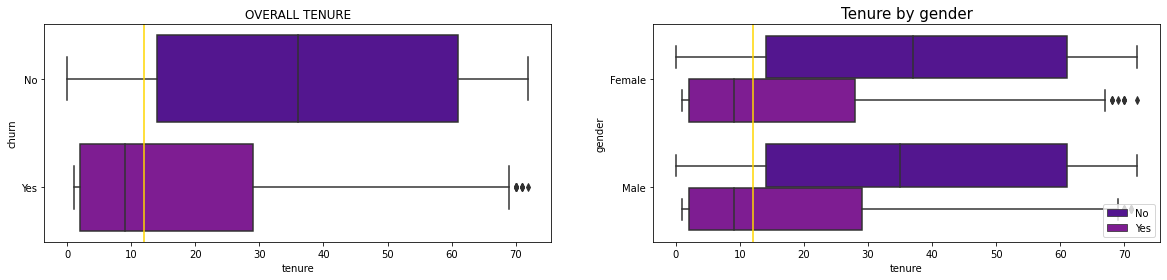

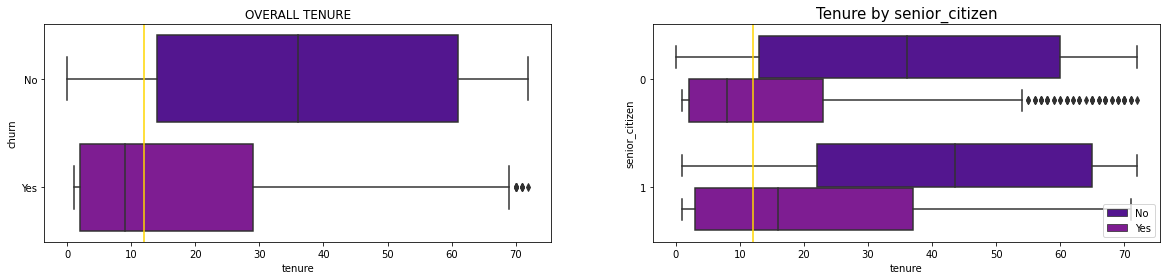

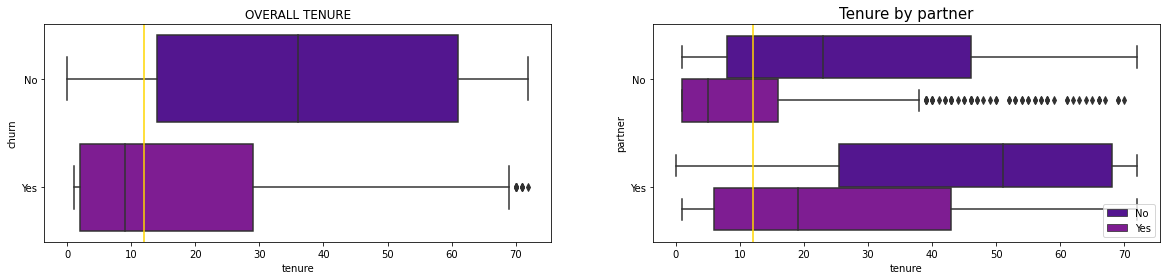

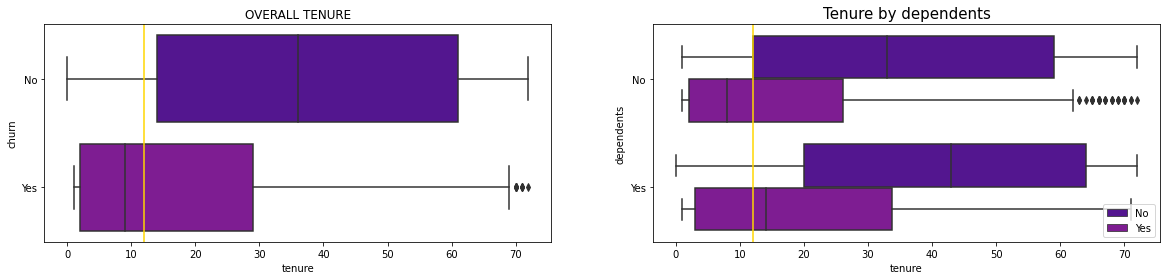

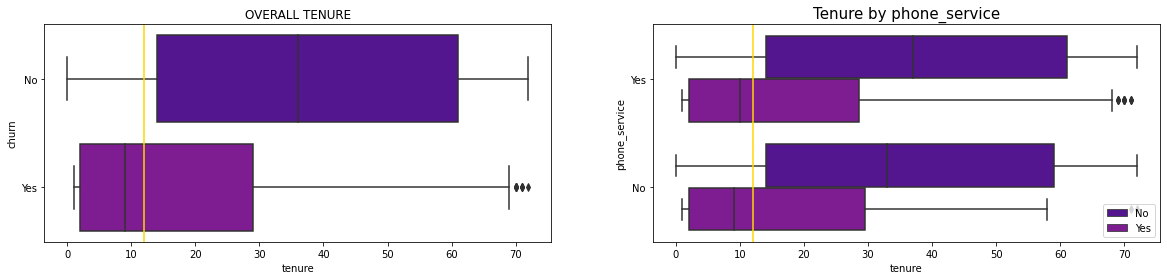

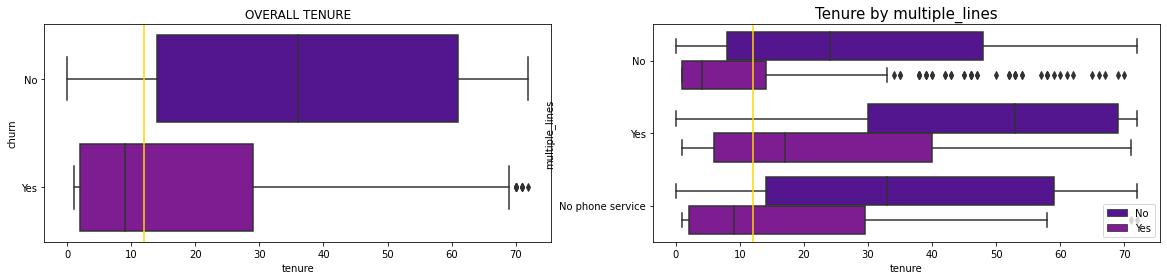

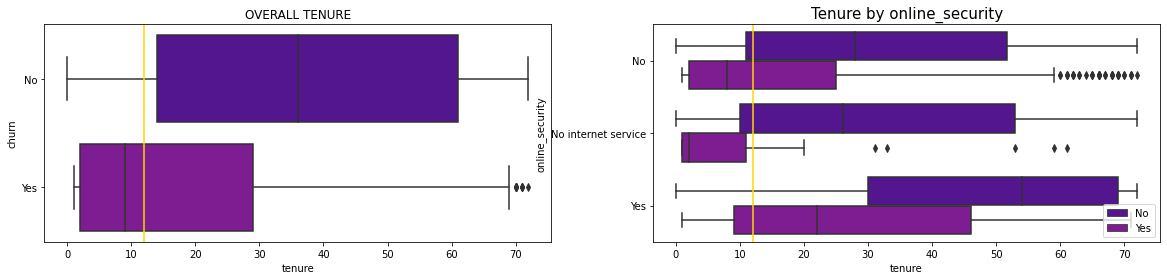

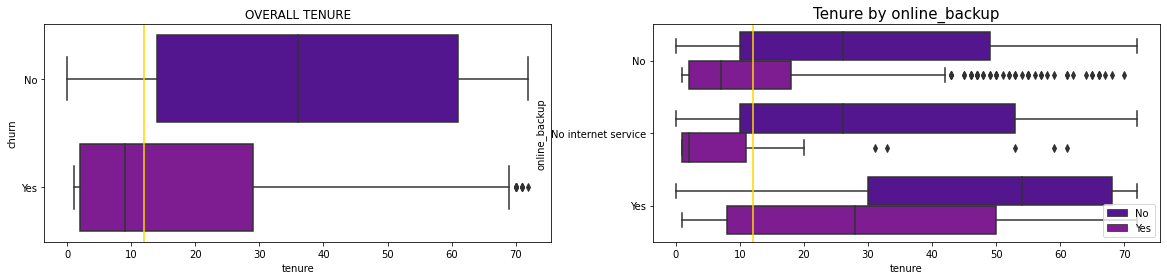

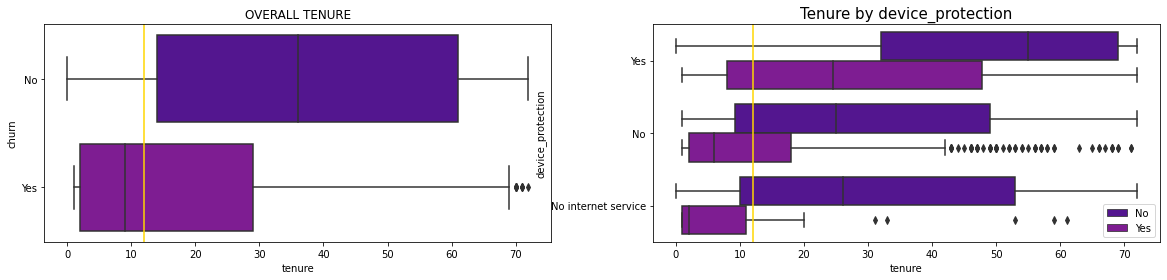

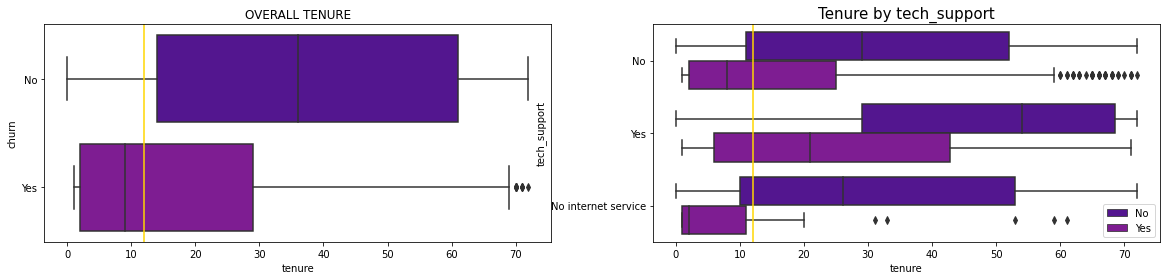

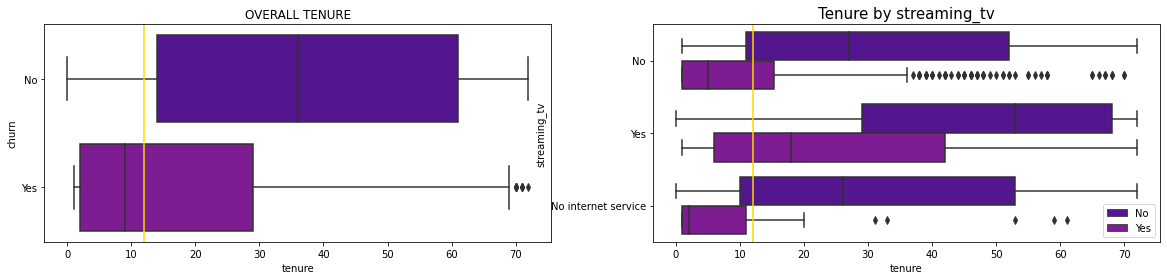

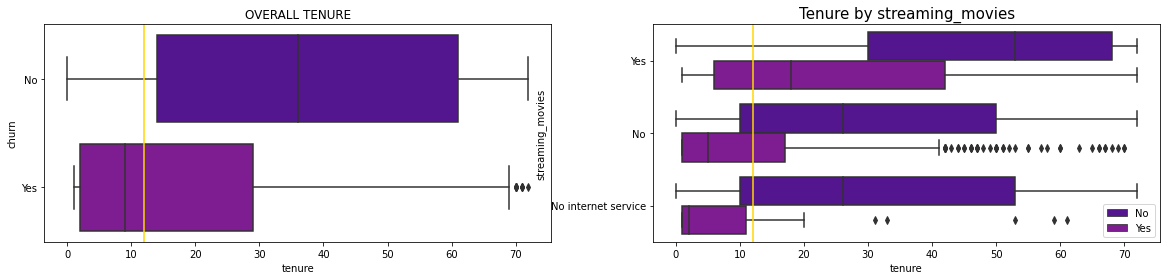

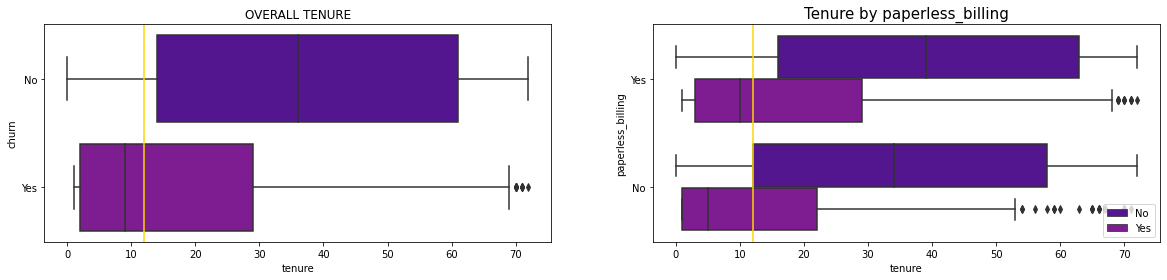

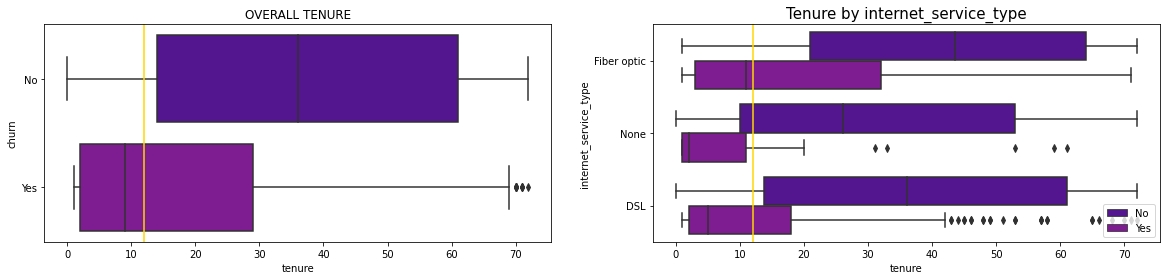

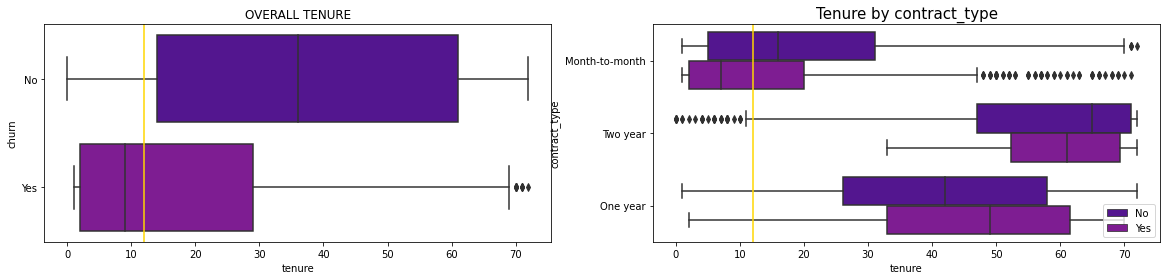

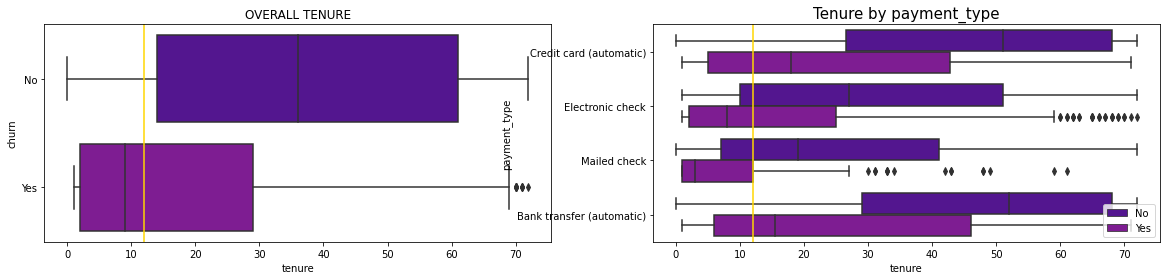

In [60]:
# gold line is for looking at customers with tenure less than a year
for col in cols_discrete:
    plt.figure(figsize = (20,4))
    plt.subplot(121)
    sns.boxplot(x = train.tenure, y = train.churn)
    plt.title('OVERALL TENURE')
    plt.axvline(x = 12, c='gold')
    
    plt.subplot(122)
    sns.boxplot(x = train.tenure, y = train[col], hue = train.churn)
    plt.legend(loc= 'lower right')
    plt.title(f'Tenure by {col}', fontsize = 15)
    plt.axvline(x = 12, c='gold')

## Takeaways from box plots
- *Not having internet*, and *paying by a mailed check*, big chunk of those customers (lower 3 quartiles) churn before 1 year
- Less significant but still big chunk of people, people who *have dsl* and *aren't in paperless billing*
- Seems like less services they have, more likely they are to churn

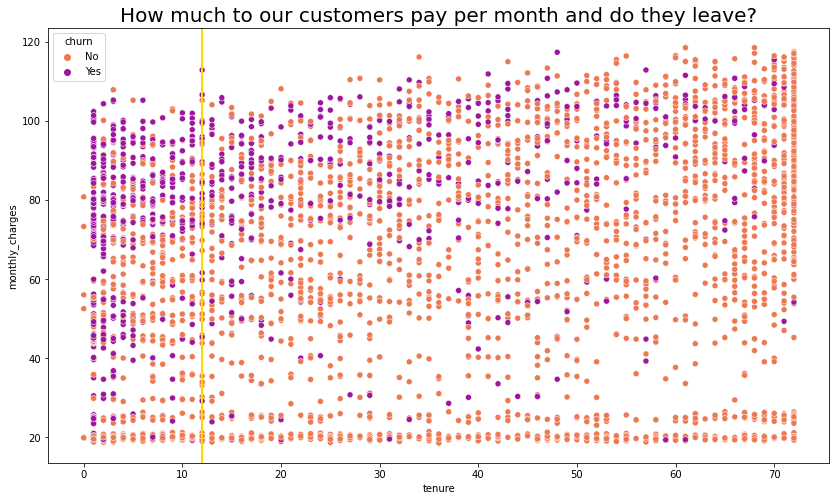

In [64]:
plt.figure(figsize = (14,8))
sns.scatterplot(x = train.tenure, y = train.monthly_charges, hue=train.churn, palette=('plasma_r'))
plt.axvline(x = 12, c = 'gold', linewidth = 2)
plt.title('How much to our customers pay per month and do they leave?', fontsize = 20)
plt.show()

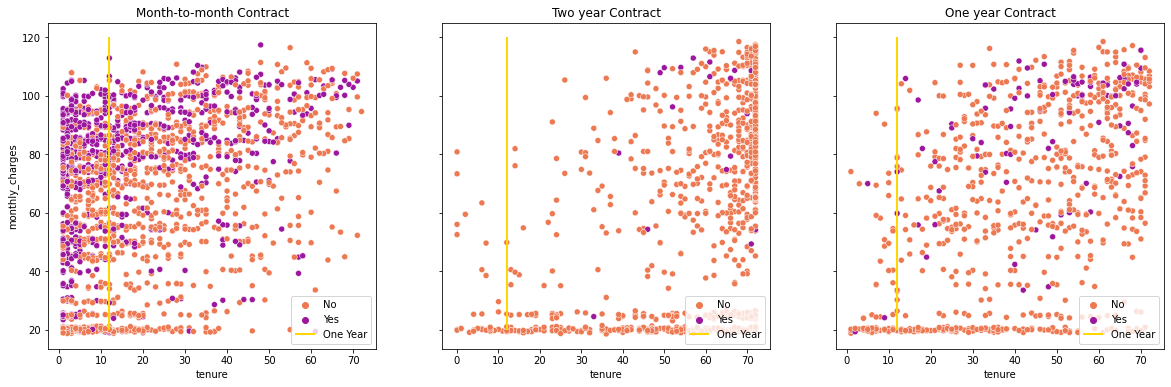

In [98]:
# create list of contract type names for my graph loop below
contract_type_list = list(train.contract_type.value_counts().index)
contract_type_list

hue_order = ['No', 'Yes']
# change colors to yellow for not churn and purple for churn and make line a different color (maybe pink)

# loop to print tenure vs contract type

#plt.figure(figsize = (20,4))
fig, axs = plt.subplots(1, 3, figsize=(20,6), sharey=True)
for ax, contract_type in zip(axs, contract_type_list):
    sns.scatterplot(x = train[train.contract_type == contract_type].tenure, y = train.monthly_charges, hue=train.churn, hue_order=hue_order, palette=('plasma_r'), ax=ax)
    ax.vlines(x = 12, ymin=20, ymax=120, color = 'gold', linewidth = 2, label = 'One Year')
    ax.set(title=f'{contract_type} Contract')
    ax.legend(loc='lower right')
    
# fig.suptitle
